In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
data = pd.read_csv('../data/energy_data_cleaned_wBuildingId.csv')

In [4]:
unique_buildings = data['building_id'].unique()

# Passo 2: embaralhar e dividir em treino, validação e teste
train_ids, temp_ids = train_test_split(unique_buildings, test_size=0.4, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# Passo 3: filtrar os dados com base nesses IDs
train_df = data[data['building_id'].isin(train_ids)].copy()
val_df = data[data['building_id'].isin(val_ids)].copy()
test_df = data[data['building_id'].isin(test_ids)].copy()

# Separar X e y
X_train = train_df.drop(['target', 'timestamp', 'building_id'], axis=1)
y_train = train_df['target']

X_val = val_df.drop(['target', 'timestamp', 'building_id'], axis=1)
y_val = val_df['target']

X_test = test_df.drop(['target', 'timestamp', 'building_id'], axis=1)
y_test = test_df['target']

In [ ]:

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# %% Scale target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


NameError: name 'X' is not defined

In [ ]:
class R2Score(tf.keras.metrics.Metric):
    def __init__(self, name='r2_metric', **kwargs):
        super().__init__(name=name, **kwargs)
        self.sse = self.add_weight(name="sse", initializer="zeros")
        self.sst = self.add_weight(name="sst", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, self.dtype)
        y_pred = tf.cast(y_pred, self.dtype)

        residual = tf.reduce_sum(tf.square(y_true - y_pred))
        total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))

        self.sse.assign_add(residual)
        self.sst.assign_add(total)

    def result(self):
        return 1.0 - (self.sse / (self.sst + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.sse.assign(0.0)
        self.sst.assign(0.0)


In [ ]:
def build_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(1)  
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='mean_squared_error', 
                  metrics=['mae', 'mse', R2Score()])
    return model
input_dim = X_train_scaled.shape[1]
model = build_model(input_dim)
model.summary()

/home/cristiano/anaconda3/envs/env_ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-11 20:12:38.879725: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        11,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,337 (743.50 KB)

 Trainable params: 188,353 (735.75 KB)

 Non-trainable params: 1,984 (7.75 KB)

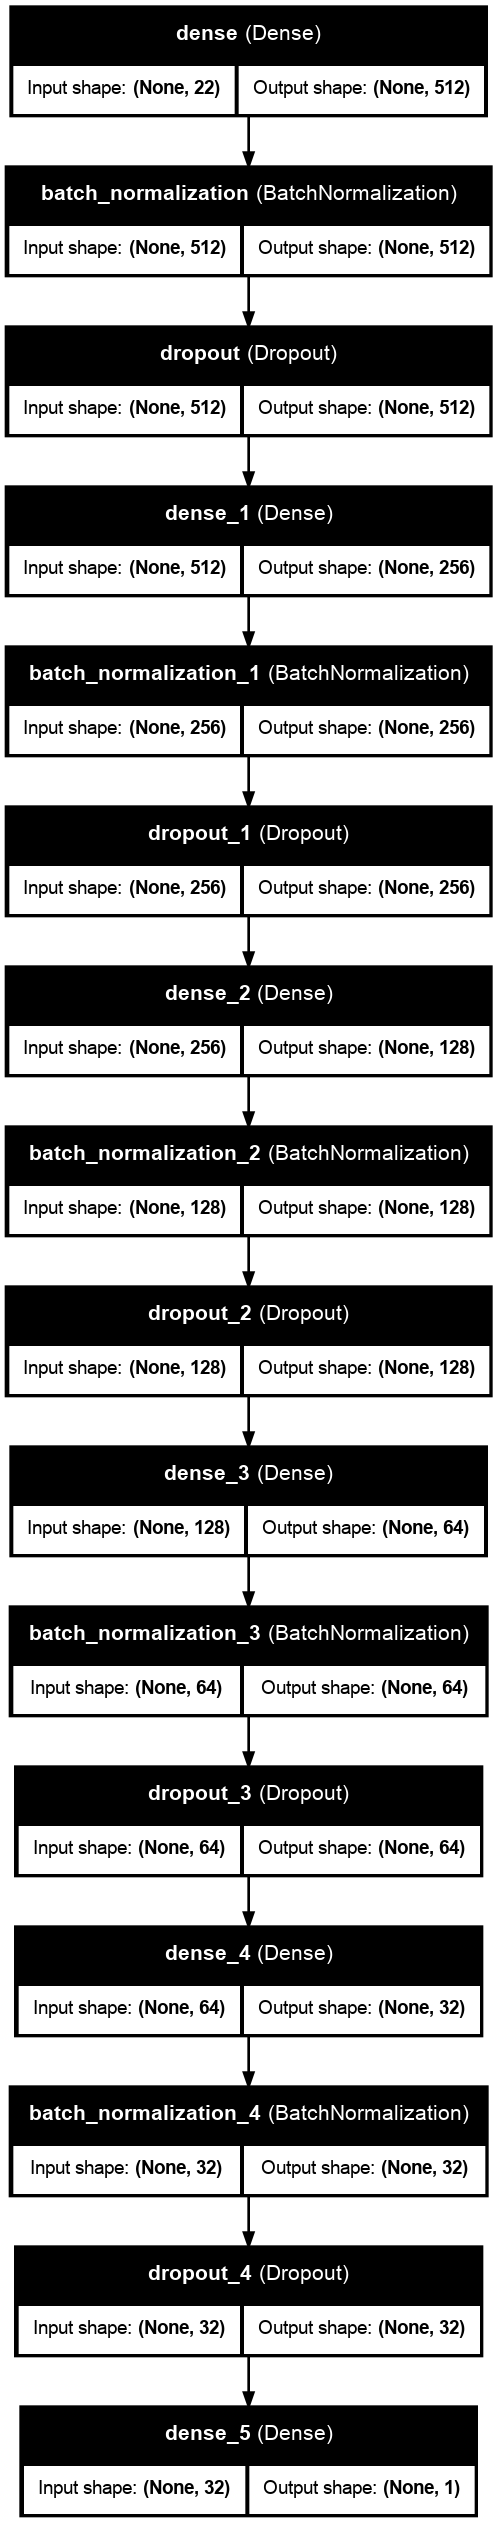

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file='model1_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)

In [ ]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50, batch_size=64, verbose=1)


Epoch 1/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 0.2836 - mae: 0.3544 - mse: 0.2836 - r2_metric: 0.7079 - val_loss: 0.0281 - val_mae: 0.1116 - val_mse: 0.0281 - val_r2_metric: 0.9712
Epoch 2/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 0.0699 - mae: 0.2010 - mse: 0.0699 - r2_metric: 0.9276 - val_loss: 0.0217 - val_mae: 0.0955 - val_mse: 0.0217 - val_r2_metric: 0.9776
Epoch 3/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 0.0615 - mae: 0.1881 - mse: 0.0615 - r2_metric: 0.9362 - val_loss: 0.0196 - val_mae: 0.0889 - val_mse: 0.0196 - val_r2_metric: 0.9799
Epoch 4/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 0.0589 - mae: 0.1837 - mse: 0.0589 - r2_metric: 0.9389 - val_loss: 0.0197 - val_mae: 0.0921 - val_mse: 0.0197 - val_r2_metric: 0.9797
Epoch 5/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 0.0576 - mae: 0.1818 - mse: 0.0576 - r2_metric: 0.9404 - val_loss: 0.0188 - val_mae: 0.0858 - val_mse: 0.0188 - val_r2_metric: 0.9806
Epoch 6/50
9829

In [ ]:
predictions_scaled = model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)
y_test_orig = scaler_y.inverse_transform(y_test_scaled)

# Métricas de desempenho
mae = mean_absolute_error(y_test_orig, predictions)
mse = mean_squared_error(y_test_orig, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, predictions)

print(f"Test- MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")


6553/6553 ━━━━━━━━━━━━━━━━━━━━ 5s 769us/step
Test- MAE: 0.1312, MSE: 0.0452, RMSE: 0.2125, R2: 0.9829


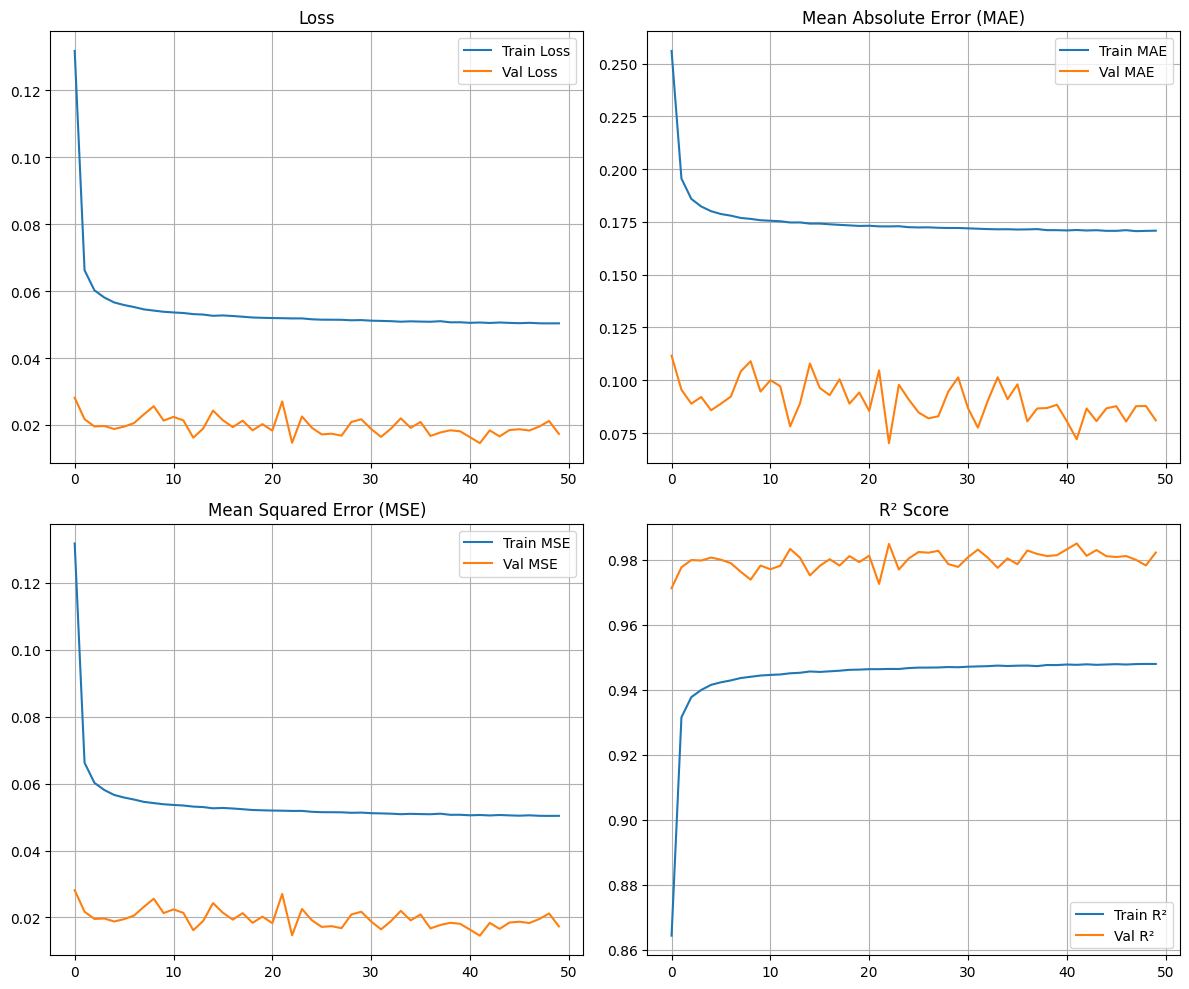

In [ ]:
# Visualização do desempenho durante o treinamento
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.grid(True)

# Plot MAE
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.grid(True)

# Plot MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend()
plt.title('Mean Squared Error (MSE)')
plt.grid(True)

# Plot R²
plt.subplot(2, 2, 4)
plt.plot(history.history['r2_metric'], label='Train R²')
plt.plot(history.history['val_r2_metric'], label='Val R²')
plt.legend()
plt.title('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

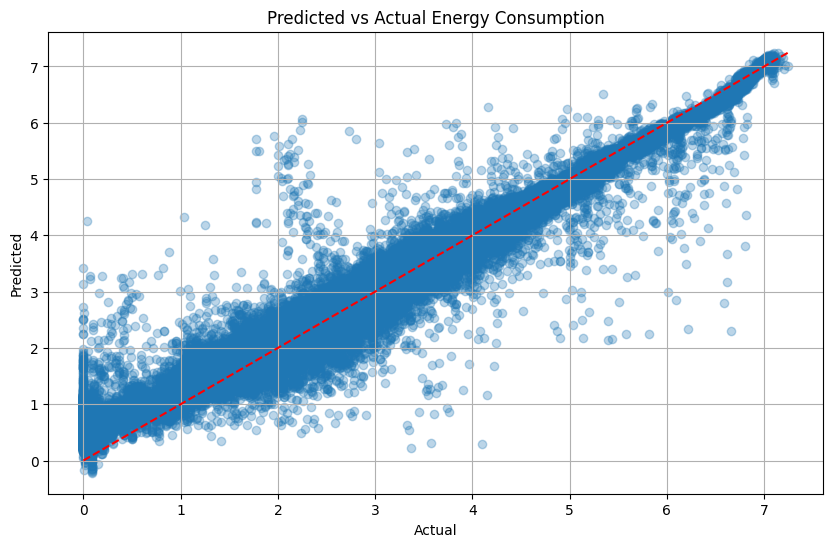

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, predictions, alpha=0.3)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Energy Consumption')
plt.grid(True)
plt.show()


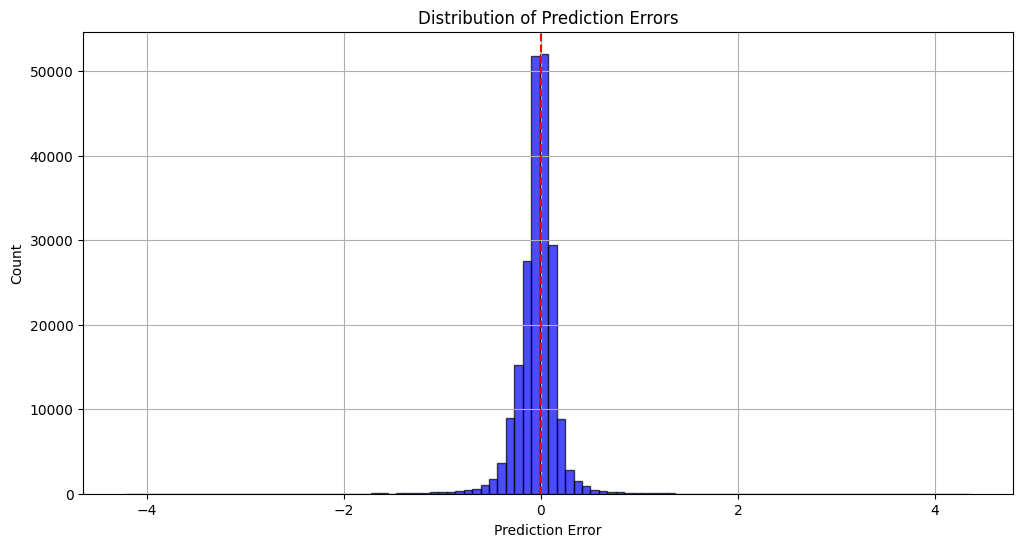

Error Analysis:
Mean Error: -0.0388
Standard Deviation of Error: 0.2089


In [ ]:
# error analysis
error = y_test_orig - predictions
plt.figure(figsize=(12, 6))
plt.hist(error, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

print("Error Analysis:")
print(f"Mean Error: {np.mean(error):.4f}")
print(f"Standard Deviation of Error: {np.std(error):.4f}")



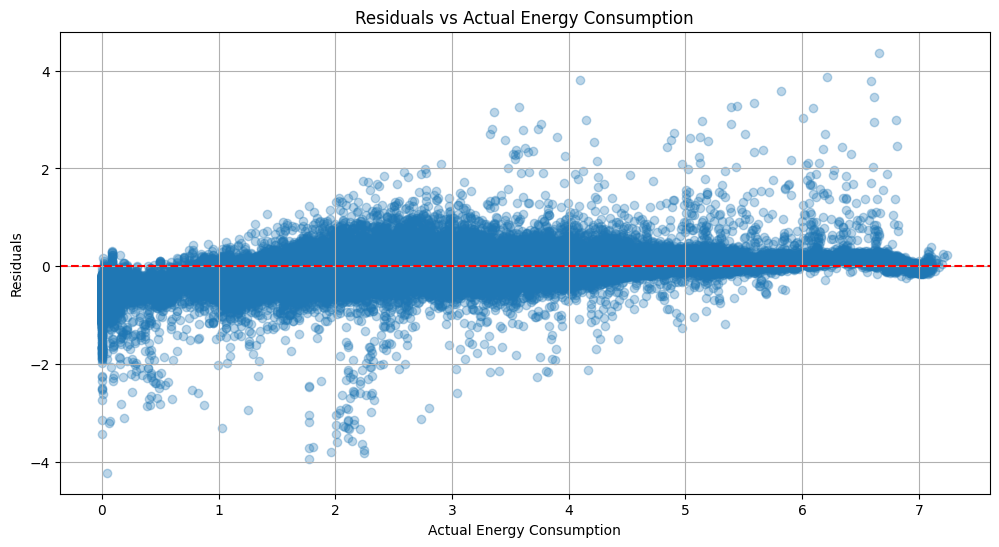

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test_orig, error, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Energy Consumption')
plt.grid(True)
plt.show()